In [72]:
#importing the library. 
import os
import zipfile
import numpy as np
import time
import cv2
import time
import random
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt
%matplotlib inline

In [73]:
#os.chdir("C:\\Users\\SouravKr\\Music\\Project\\Project")
print (os.getcwd())

C:\Users\SouravKr\Music\Project\Project


In [74]:
#Setting up the path 
yolo_path = 'Yolo/Model'
sdd_path = 'SSD/models'
rcnn_path ='RCNN/model' 

In [75]:
#Setting up Color
yolo_color = (255,0,0)
sdd_color = (0,255,0)
rcnn_color = (0,0,255)

In [76]:
#Setting up the configuration values 
image_dir_master = "Images"
confidence_value = 0.5
threshold_value = 0.3

## Set UP 

In [77]:
#Yolo
"""
Created on Fri Jul 4 15:50:52 2019

@author: Akila
"""
yoloClassPath = os.path.sep.join([yolo_path, "coco.names"])
yoloClassName = open(yoloClassPath).read().strip().split("\n")
# assigning different color_value to each class label. 
np.random.seed(42)
 
yolo_color_value = np.random.randint(0, 1, size=(len(yoloClassPath), 3),dtype="uint8")

# derive the paths to the YOLO weights and model configuration
yoloWeights_dir = os.path.sep.join([yolo_path, "yolov3.weights"])
yoloConfig_dir = os.path.sep.join([yolo_path, "yolov3.cfg"])

# load the COCO class labels with which our Yolo model has been trained. 80 classes. 
print("[INFO] Loaded YOLO from disk...")
yoloNet = cv2.dnn.readNetFromDarknet(yoloConfig_dir, yoloWeights_dir)

[INFO] Loaded YOLO from disk...


In [78]:
#SSD
"""
Created on Fri Jul 4 15:50:52 2019

@author: Shrutin
"""
ssdClassNames = { 0: 'background',
            1: 'bench', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus',
            7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant',12:'tooth brush',
            13: 'stop sign', 14: 'parking meter', 15: 'person', 16: 'bird', 17: 'cat',
            18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear',
            24: 'zebra', 25: 'giraffe', 27: 'backpack', 28: 'umbrella', 31: 'handbag',
            32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard',
            37: 'sports ball', 38: 'kite', 39: 'baseball bat', 40: 'baseball glove',
            41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle',
            46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon',
            51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange',
            56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut',
            61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed',
            67: 'dining table', 70: 'toilet', 72: 'tv', 73: 'laptop', 74: 'mouse',
            75: 'remote', 76: 'keyboard', 77: 'cell phone', 78: 'microwave', 79: 'oven',
            80: 'toaster', 81: 'sink', 82: 'refrigerator', 84: 'book', 85: 'clock',
            86: 'vase', 87: 'scissors', 88: 'teddy bear', 89: 'hair drier', 90: 'toothbrush' }

 

# load our serialized model from disk
print("[INFO] Loaded SSD Model from disk...")

ssdNet = cv2.dnn.readNetFromCaffe(os.path.sep.join([sdd_path,"MobileNetSSD_deploy.prototxt.txt"]), os.path.sep.join([sdd_path ,"MobileNetSSD_deploy.caffemodel"]))

[INFO] Loaded SSD Model from disk...


In [79]:
# Mask RCNN
"""
Created on Fri Jul 4 15:50:52 2019

@author: Swathi
"""
mrcnnlabelsPath = os.path.sep.join([rcnn_path,"object_detection_classes_coco.txt"])
mrcnnLABELS = open(mrcnnlabelsPath).read().strip().split("\n")

# derive the paths to the Mask R-CNN weights and model configuration
mrcnnWeightsPath = os.path.sep.join([rcnn_path,"frozen_inference_graph.pb"])
mrcnnConfigPath = os.path.sep.join([rcnn_path, "mask_rcnn_inception_v2_coco_2018_01_28.pbtxt"])

# load our Mask R-CNN trained on the COCO dataset (90 classes)
# from disk
print("[INFO] Loaded Mask R-CNN from disk...")
mrcnnNet = cv2.dnn.readNetFromTensorflow(mrcnnWeightsPath, mrcnnConfigPath)

[INFO] Loaded Mask R-CNN from disk...


## YOLO

In [80]:
"""
Created on Fri Jul 4 15:50:52 2019

@author: Akila
"""
#YOLO
def yolo_function(image_view,getcoordinates):   
  # loading and finding the dimension of image_view 

  (height, width) = image_view.shape[:2]
  global yolo_total_object
  global yolo_time_taken    

  # finding the output layer 
  output_layer = yoloNet.getLayerNames()
  output_layer = [output_layer[i[0] - 1] for i in yoloNet.getUnconnectedOutLayers()]

  #  doing a forward pass in yolo and proving bonding boxed with high probability area
  bounding_box = cv2.dnn.blobFromImage(image_view, 1 / 255.0, (416, 416), swapRB=True, crop=False)
  yoloNet.setInput(bounding_box)
  start = time.time()
  layer_area_output = yoloNet.forward(output_layer)
  end = time.time()

  # total time taken to analysis the image_view
  #print("[INFO] YOLO took {:.6f} seconds".format(end - start))
  yolo_time_taken = (end - start)
   
  #assigning array values to the prediction area 
  area_of_interest_box = []
  area_of_interest_boundingbox = []
  area_of_confidence = []
  class_value_IDs = []

  
  # iteration over all area of interest 
  for area_output in layer_area_output:
  	# iteration over all area of area_detection
  	for area_detection in area_output:
  		#  
  		scores_prediction_value = area_detection[5:]
  		detected_class_val = np.argmax(scores_prediction_value)
  		model_prediction_confidence = scores_prediction_value[detected_class_val]
      
  	    #considering all the model predicted confidence value more than user input. 
  		if model_prediction_confidence > confidence_value:
  			# making bounding boxes as per model suggested coordinates
  			box = area_detection[0:4] * np.array([width, height, width, height])
  			(centerX, centerY, width, height) = box.astype("int")
  
  			x_axis = int(centerX - (width / 2))
  			y_axis = int(centerY - (height / 2))
  
  			# updating the list with its values. 
  			area_of_interest_box.append([x_axis, y_axis, int(width), int(height)])
  			area_of_confidence.append(float(model_prediction_confidence))
  			class_value_IDs.append(detected_class_val)
  
  # apply non-maxima suppression to suppress weak, overlapping bounding
  # area_of_interest_box
  feature_area_detection = cv2.dnn.NMSBoxes(area_of_interest_box, area_of_confidence, confidence_value, threshold_value)     
  # considering atleast one area of interest predicted
  if len(feature_area_detection) > 0:
  	# iteration over the indexes we are keeping
  	for i in feature_area_detection.flatten():
  		#getting the bounding box coordinates  
  		(x_axis, y_axis) = (area_of_interest_box[i][0], area_of_interest_box[i][1])
  		(width, height) = (area_of_interest_box[i][2], area_of_interest_box[i][3])
  
  		# labeling the image_view and drawing the bounding box
  		cv2.rectangle(image_view, (x_axis, y_axis), (x_axis + width, y_axis + height), yolo_color, 2)
  		text = "{}: {:.4f}".format(yoloClassName[class_value_IDs[i]], area_of_confidence[i])
  		cv2.putText(image_view, text, (x_axis, y_axis - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, yolo_color, 2)
  		yolo_total_object = yolo_total_object + 1
  		yolo_time_taken = end - start
  		area_of_interest_boundingbox.append([x_axis, y_axis, int(x_axis + width), int(y_axis + height)])
        
          
  # return result
  if getcoordinates == True:
    if len(area_of_interest_boundingbox) != 0:
        return area_of_interest_boundingbox
    else:
        return 0
  else:
    return image_view


## SSD


In [81]:
def ssd_function(image_view,getcoordinates):     
  
  (height, width) = image_view.shape[:2]
  global sdd_time_taken
  global sdd_total_object
  bounding_box = cv2.dnn.blobFromImage(cv2.resize(image_view, (512, 512)), 0.007843, (512, 512), 127.5)

  # pass the bounding_box through the network and obtain the area_detections and
  # predictions
  area_of_interest_boundingbox = []
  ssdNet.setInput(bounding_box)
  start = time.time()
  area_detections = ssdNet.forward()
  end = time.time()

  # show timing information on YOLO   
  count = 0
  # iteration over the area_detections
  for i in np.arange(0, area_detections.shape[2]):
    # getting the model_prediction_confidence  associated with the probability prediction
    model_prediction_confidence = area_detections[0, 0, i, 2]
   
    # removing out weak detection by ensuring the `model_prediction_confidence` is
    # greater than the minimum model_prediction_confidence
    if model_prediction_confidence > confidence_value:
           class_id_x = int(area_detections[0, 0, i, 1])
           area_of_interest_box = area_detections[0, 0, i, 3:7] * np.array([width, height, width, height])
           (start_Xaxis, start_Yaxis, end_Xaxis, end_Yaxis) = area_of_interest_box.astype("int")
           area_of_interest_boundingbox.append([start_Xaxis, start_Yaxis, int(end_Xaxis), int(end_Yaxis)])
           label_text_value = "{}: {:.2f}%".format(ssdClassNames[class_id_x], model_prediction_confidence * 100)           
           cv2.rectangle(image_view, (start_Xaxis, start_Yaxis), (end_Xaxis, end_Yaxis),sdd_color, 2)
           y_axis = start_Yaxis - 15 if start_Yaxis - 15 > 15 else start_Yaxis + 15
           cv2.putText(image_view, label_text_value, (start_Xaxis, y_axis), cv2.FONT_HERSHEY_SIMPLEX, 0.5, sdd_color, 2)
           count = count + 1
           sdd_total_object = sdd_total_object + 1
           sdd_time_taken = (end - start)
           
            
        

  if getcoordinates == True:
    if len(area_of_interest_boundingbox) != 0:
        return area_of_interest_boundingbox
    else:
        return 0
  else:
    return image_view

In [82]:
# MASK RCNN
"""
Created on Fri Jul 4 15:50:52 2019

@author: Swathi
"""

def maskrcnn_function(image_view,getcoordinates):
    (height, width) = image_view.shape[:2]
    global mask_total_object
    global mask_rcnn_time_taken
    # pass the bounding_box through the network and obtain the area_detections and
    # predictions
    area_of_interest_boundingbox = []
    bounding_box = cv2.dnn.blobFromImage(image_view, swapRB=True, crop=False)
    mrcnnNet.setInput(bounding_box)
    start = time.time()
    (area_of_interest_box_rcnn, masks) = mrcnnNet.forward(["detection_out_final", "detection_masks"])
    end = time.time()
    # show timing information and volume information on Mask R-CNN
    #print("[INFO] Mask R-CNN took {:.6f} seconds".format(end - start))
    clone = image_view.copy()
  

    # loop over the number of detected objects
    for i in range(0, area_of_interest_box_rcnn.shape[2]):
    	# extract the class ID of the detection along with the confidence
    	# (i.e., probability) associated with the prediction
    	classID = int(area_of_interest_box_rcnn[0, 0, i, 1])
    	confidence = area_of_interest_box_rcnn[0, 0, i, 2]
    	count = 0
    	# filter out weak predictions by ensuring the detected probability
    	# is greater than the minimum probability
    	if confidence > confidence_value:            
    		box = area_of_interest_box_rcnn[0, 0, i, 3:7] * np.array([width, height, width, height])
    		(startX, startY, endX, endY) = box.astype("int")
    		boxW = endX - startX
    		boxH = endY - startY
    		area_of_interest_boundingbox.append([startX, startY, int(endX), int(endY)])
            
    
    		# extract the pixel-wise segmentation for the object, resize
    		# the mask such that it's the same dimensions of the bounding
    		# box, and then finally threshold to create a *binary* mask
    		mask = masks[i, classID]
    		mask = cv2.resize(mask, (boxW, boxH),
    			interpolation=cv2.INTER_NEAREST)
    		mask = (mask > threshold_value)
    
    		# extract the ROI of the image
    		roi = clone[startY:endY, startX:endX]
    
    		# check to see if are going to visualize how to extract the
    		# masked region itself
    		if True:
    			# convert the mask from a boolean to an integer mask with
    			# to values: 0 or 255, then apply the mask
    			visMask = (mask * 255).astype("uint8")
    			instance = cv2.bitwise_and(roi, roi, mask=visMask)
   
    		# now, extract *only* the masked region of the ROI by passing
    		# in the boolean mask array as our slice condition
    		roi = roi[mask]
    
    		# randomly select a color that will be used to visualize this
    		# particular instance segmentation then create a transparent
    		# overlay by blending the randomly selected color with the ROI 
            
    		blended = ((0.4 * 1) + (0.6 * roi)).astype("uint8")
    
    		# store the blended ROI in the original image
    		clone[startY:endY, startX:endX][mask] = blended
    
    		# draw the bounding box of the instance on the image
    		color =rcnn_color
    		cv2.rectangle(clone, (startX, startY), (endX, endY), color, 2)
    
    		# draw the predicted label and associated probability of the
    		# instance segmentation on the image
    		text = "{}: {:.4f}".format(mrcnnLABELS[classID], confidence)
        
    		cv2.putText(clone, text, (startX, startY - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    		count = count + 1
    		mask_rcnn_time_taken = (end - start)
    		mask_total_object = mask_total_object + 1
    
    
    if getcoordinates == True:
        if len(area_of_interest_boundingbox) != 0:
            return area_of_interest_boundingbox
        else:
            return 0
            
    
    return clone
      
  

In [83]:
# %load Annotation/annotation.py
# -*- coding: utf-8 -*-
"""
Created on Fri Jul 26 15:50:52 2019

@author: Mounika
"""

myfile = open("Annotation/annotation.txt")
area_of_interest_box = []

def sumOfAP(a,d,n):
    return a+d * int(n-1)
    
def find_annotation(image_id):
    for line in myfile:    
        text = line       
        text = text.split(',')
        count = 0
        i = 1
       
        for x in range(len(text)):                     
            if (text[0] == image_id):
                #print(text[x])
                count = text[1]
                
        for y in range(int(count)):            
            if (text[0] == image_id):    
                #area  
                area_of_interest_box.append([text[sumOfAP(3,6,i)], text[sumOfAP(4,6,i)], text[sumOfAP(5,6,i)], text[sumOfAP(6,6,i)]])
                i = i + 1
            else:
                return 0         
    return area_of_interest_box

def coordinatesDescription(shape):     
    x1, y1 = int(shape[0]), int(shape[1])
    x2, y2 = (int(shape[0]) + int(shape[2])), (int(shape[3])+int(shape[1]))
    return x1,y1,x2,y2
    
def Annotation_boundingBoxes(image_view,imgID,getcoordinates):
    boxes = find_annotation(imgID)
    area_of_interest_boundingbox = []
    for box in boxes:        
        #image_view = cv2.resize(image_view, (600,600))
        #print(box)
        x1, y1, x2, y2 = coordinatesDescription(box)
        cv2.rectangle(image_view, (x1,y1),(x2,y2),(64, 224, 208),3)            
        #cv2.imshow("s",image_view)
        #cv2.waitKey(0)
        area_of_interest_boundingbox.append([x1,y1,x2,y2])
    
    if getcoordinates == True:
        if len(area_of_interest_boundingbox) != 0:
            return area_of_interest_boundingbox
        else:
            return 0
    else:
        return image_view

#image_path_dir = "mages//PIC569.jpg"
#image_view =  cv2.imread(image_path_dir)            
#returnvalue = Annotation_boundingBoxes(image_view,"PIC569.jpg")
#print(returnvalue)

# Comparison

Image:IMG_50004.jpg
Image:IMG_50004.jpg Yolo Processing 


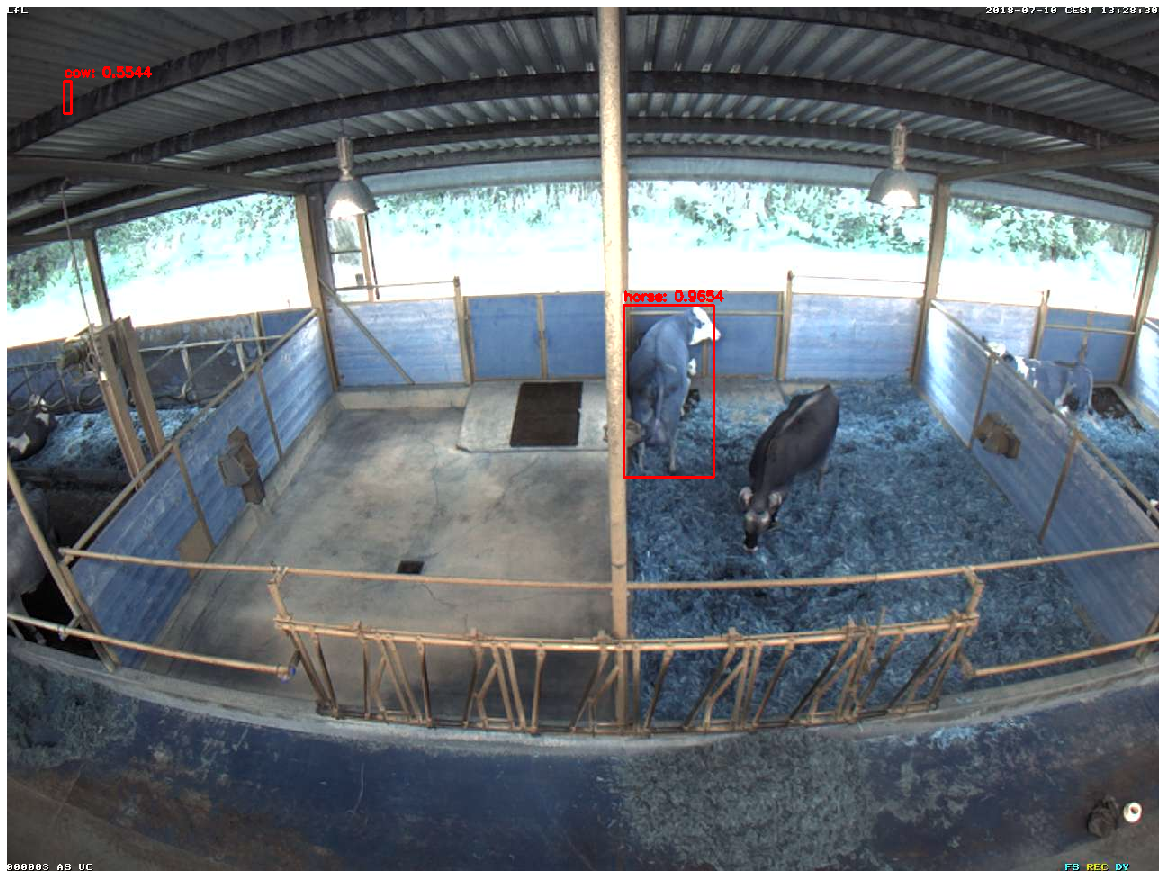

Image:IMG_50004.jpg SSD Processing 


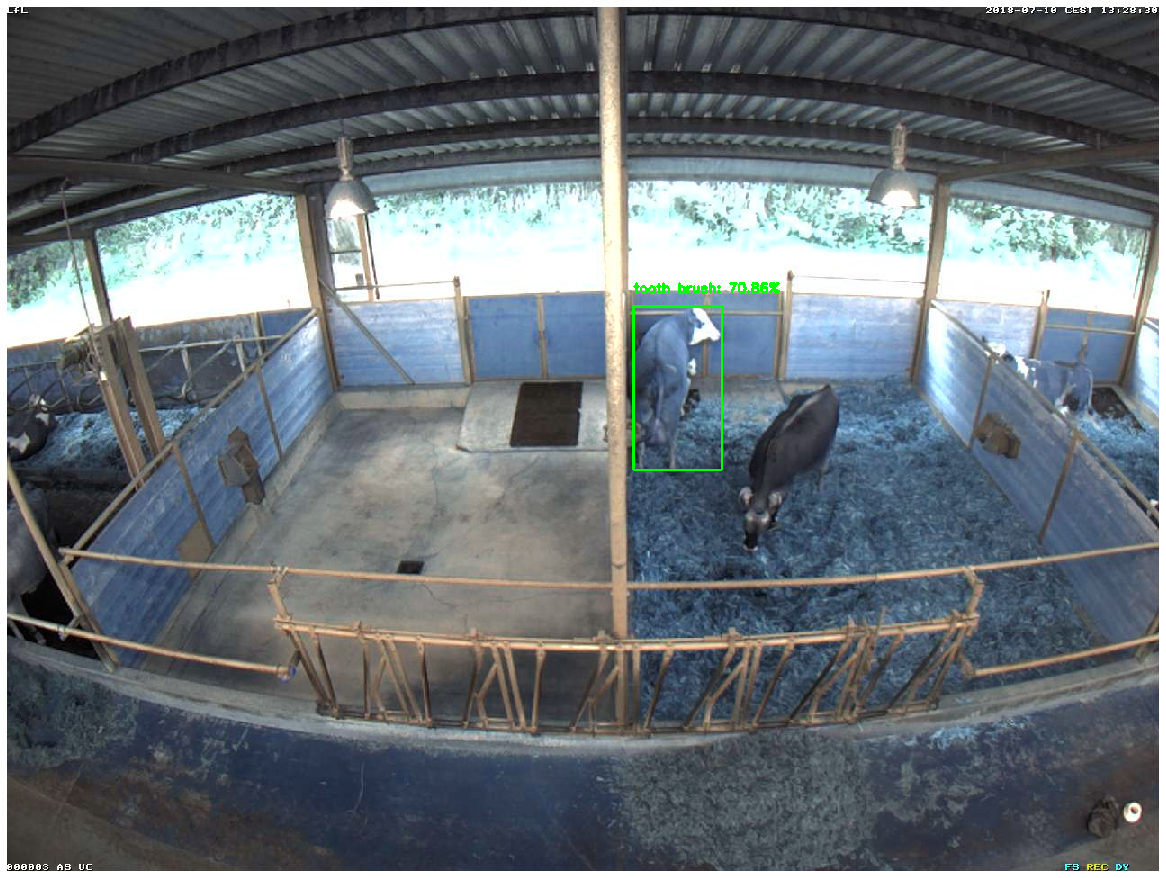

Image:IMG_50004.jpg MASK RCNN Processing 


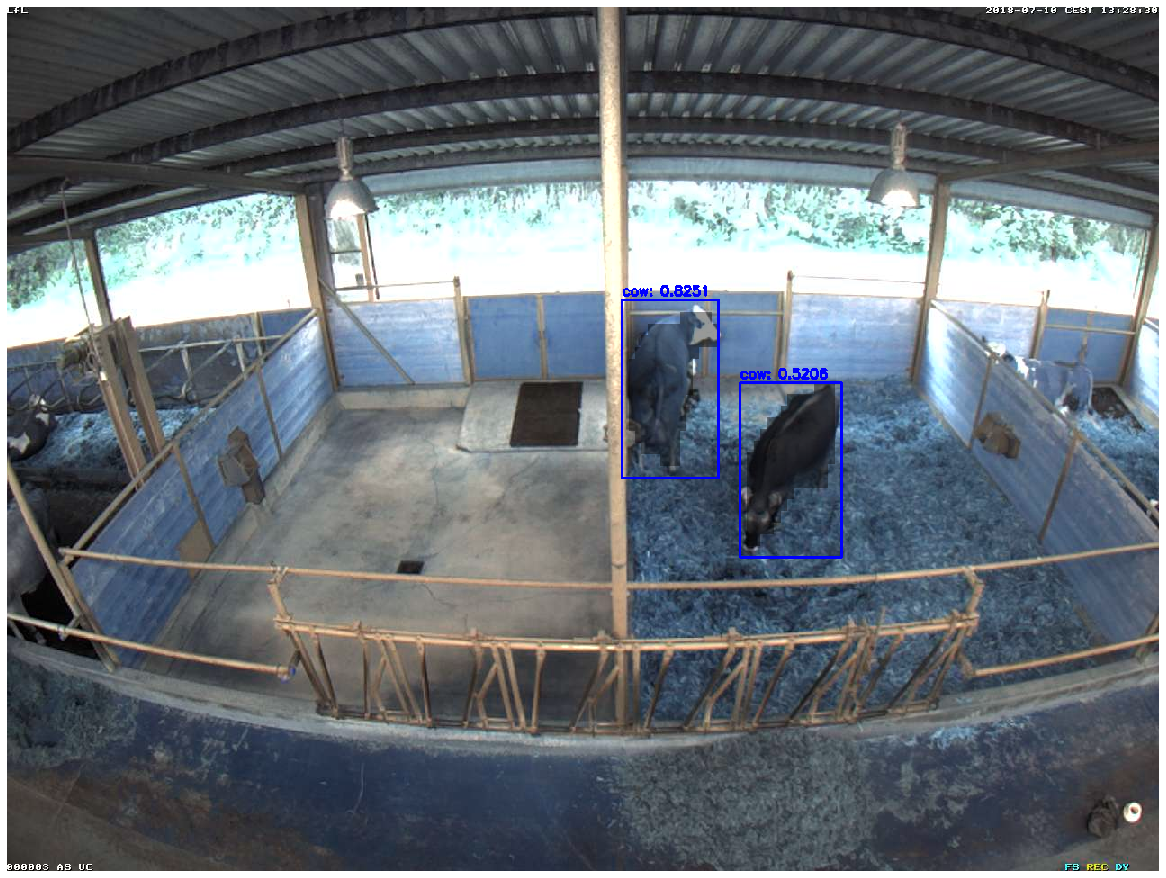

Image:IMG_50004.jpg ANNOTATION Processing 


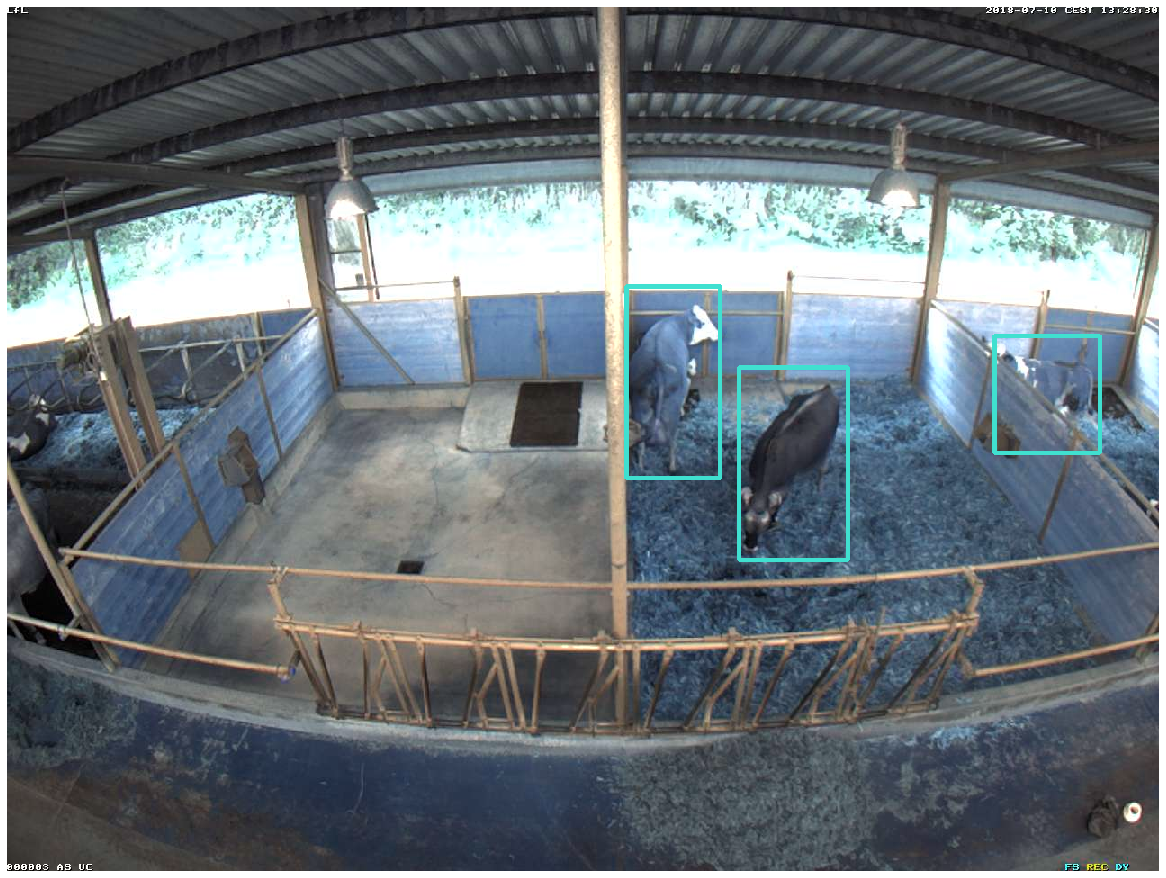

In [84]:
%matplotlib inline
"""
Created on Fri Jul 4 15:50:52 2019

@author: Sourav Kumar
""" 

#validating the time required by each model to process the image
yolo_time_taken = 0
sdd_time_taken = 0
mask_rcnn_time_taken =0

#validating total Image detected
yolo_total_object = 0
sdd_total_object =  0
mask_total_object = 0


def display_image(im_path,image_view_data):

    dpi = 80
    im_data = plt.imread(im_path)
    height, width, depth = im_data.shape
    figsize = width / float(dpi), height / float(dpi)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    ax.imshow(image_view_data)

    plt.show()


files = [f for f in listdir(image_dir_master) if isfile(join(image_dir_master, f))]
for file in files:    
    
    image_path_dir = os.path.sep.join([image_dir_master, file])
    image_view =  cv2.imread(image_path_dir)
   
    print("Image:" + file)
    yolo_copy_img = image_view.copy()   
    ssd_copy_img = image_view.copy()     
    mark_rcnn_copy_image = image_view.copy() 
    annoted_copy_image = image_view.copy() 
     
    
    yolo_img = yolo_function(yolo_copy_img,False)    
    ssd_img = ssd_function(ssd_copy_img,False)       
    mark_rcnn_image = maskrcnn_function(mark_rcnn_copy_image,False)    
    annoted_image = Annotation_boundingBoxes(annoted_copy_image,file,False)
    
    ## SHow Image
    print("Image:" + file + " Yolo Processing ")
    display_image(image_path_dir,yolo_img)
    print("Image:" + file + " SSD Processing ")
    display_image(image_path_dir,ssd_img)
    print("Image:" + file + " MASK RCNN Processing ")
    display_image(image_path_dir,mark_rcnn_image)
    print("Image:" + file + " ANNOTATION Processing ")
    display_image(image_path_dir,annoted_image)

In [85]:
print("Yolo total object detected : " + str(yolo_total_object) + ", total sec took : " + str(yolo_time_taken))
print("SSD total object detected : " + str(sdd_total_object) + " , total sec took : " + str(sdd_time_taken))
print("MASK RCNN total object detected : " + str(mask_total_object) + ", total sec took : " + str(mask_rcnn_time_taken)) 

Yolo total object detected : 2, total sec took : 0.9586868286132812
SSD total object detected : 1 , total sec took : 0.16378307342529297
MASK RCNN total object detected : 2, total sec took : 3.7190325260162354


# Analysis Measure IoU (Intersection over Union)

Image:IMG_50004.jpg
 IOU for MASKRCNN :  0.8735137438738547 , for Image object:1
 IOU for MASKRCNN :  0.0 , for Image object:1
 IOU for SSD :  0.7773252758801892 , for Image object:1
 IOU for Yolo :  0.8164540484248893 , for Image object:1
 IOU for Yolo :  0.0 , for Image object:1
 IOU for MASKRCNN :  0.0 , for Image object:2
 IOU for MASKRCNN :  0.8475028593213877 , for Image object:2
 IOU for SSD :  0.0 , for Image object:2
 IOU for Yolo :  0.0 , for Image object:2
 IOU for Yolo :  0.0 , for Image object:2
 IOU for MASKRCNN :  0.0 , for Image object:3
 IOU for MASKRCNN :  0.0 , for Image object:3
 IOU for SSD :  0.0 , for Image object:3
 IOU for Yolo :  0.0 , for Image object:3
 IOU for Yolo :  0.0 , for Image object:3


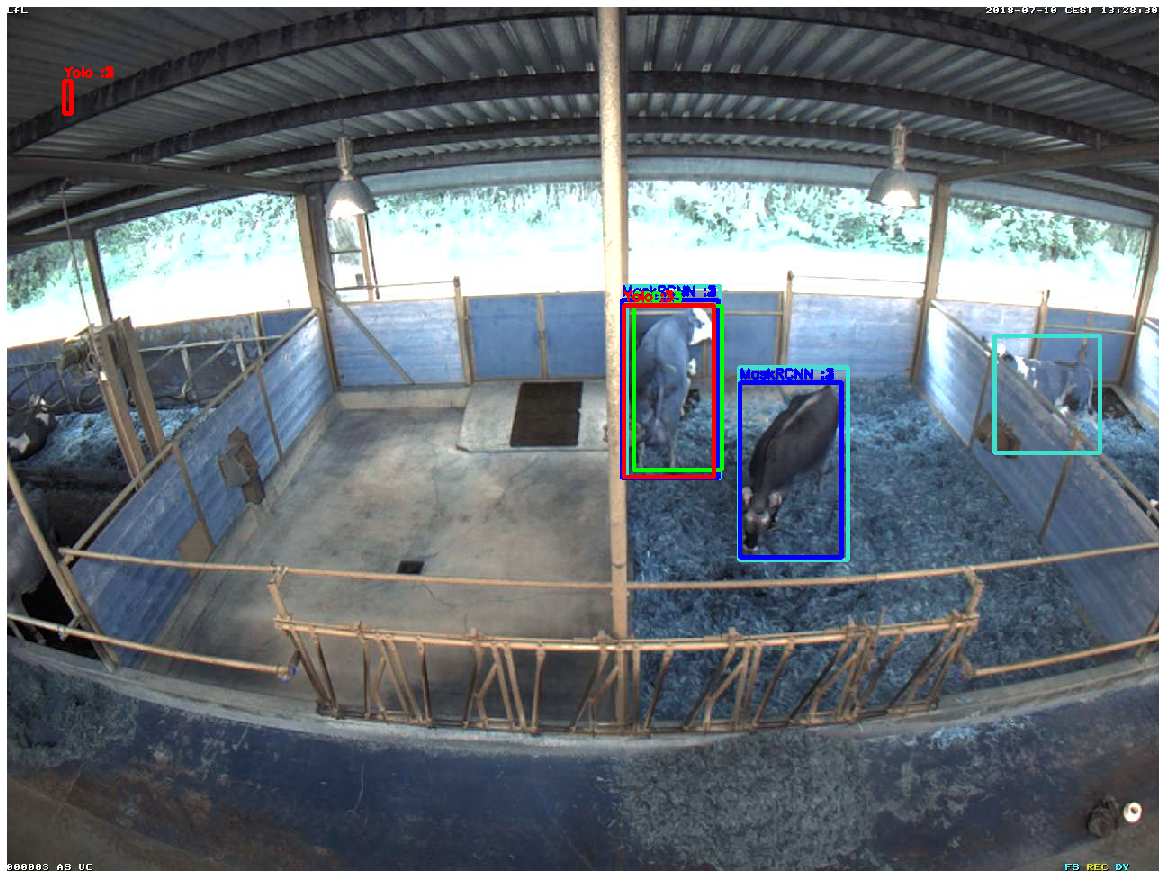

In [93]:
"""
Created on Fri Jul 26 15:50:52 2019

@author: Sourav Kumar
"""

def intersection_over_union(boundingBoxA, boundingBoxB):
	# determine the (x, y)-coordinates of the intersection rectangle
    
	(A0, A1, A2, A3) = np.array(boundingBoxA, dtype=np.int)
	(B0, B1, B2, B3) = np.array(boundingBoxB, dtype=np.int)   
    
	x1 = max(A0, B0)
	y1 = max(A1, B1)
	x2 = min(A2, B2)
	y2 = min(A3, B3)
 
	# compute the area of intersection rectangle
	interArea = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
 
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (A2 - A0 + 1) * (A3 - A1 + 1)
	boxBArea = (B2 - B0 + 1) * (B3 - B1 + 1)
 

	iou = interArea / float(boxAArea + boxBArea - interArea)
 
	# return the intersection over union value
	return iou

files = [f for f in listdir(image_dir_master) if isfile(join(image_dir_master, f))]
for file in files:    
    
    image_path_dir = os.path.sep.join([image_dir_master, file])
    image_view =  cv2.imread(image_path_dir)
   
    print("Image:" + file)
    yolo_copy_img = image_view.copy()   
    ssd_copy_img = image_view.copy()     
    mark_rcnn_copy_image = image_view.copy() 
    annoted_copy_image = image_view.copy()
     
    
    yolo_box_coordinate = yolo_function(yolo_copy_img,True)
    ssd_box_coordinate = ssd_function(ssd_copy_img, True)     
    mark_rcnn_box_coordinate = maskrcnn_function(mark_rcnn_copy_image, True)     
    annoted_box_coordinate = Annotation_boundingBoxes(annoted_copy_image,file, True)     
    
    #print(yolo_box_coordinate)
    #print(ssd_box_coordinate)
    #print(mark_rcnn_box_coordinate)
    #print(annoted_box_coordinate)
    
    #boxA = [2392, 573, 245, 186]
    #boxB = [2397, 550, 284, 227]
    #print(intersection_over_union(boxA, boxB))
    #cv2.rectangle(image_view, (43, 61),(156, 50), (0, 255, 0), 2)
    #cv2.rectangle(image_view, (45, 58,),( 157, 54), (255, 255, 0), 2)
    #cv2.imshow("Image", image_view)
    #cv2.waitKey(0)
    objectID =0
    for coval in annoted_box_coordinate:
        x1,y1,w1,h1 = np.array(coval, dtype=np.int)
        objectID = objectID + 1
        cv2.rectangle(image_view, (x1,y1),(w1,h1),(64, 224, 208),3) 
        
        if mark_rcnn_box_coordinate != 0:
            for ccval in mark_rcnn_box_coordinate:
                x,y,w,h = np.array(ccval, dtype=np.int)
                cv2.rectangle(image_view, (x,y),(w,h),rcnn_color,3)
                cv2.putText(image_view, "MaskRCNN :" +str(objectID) +"", (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, rcnn_color, 2)
                print(" IOU for MASKRCNN :  " + str(intersection_over_union(ccval, coval)) + " , for Image object:" + str(objectID))

        if ssd_box_coordinate != 0:
            for ccval in ssd_box_coordinate:
                x,y,w,h = np.array(ccval, dtype=np.int)
                cv2.rectangle(image_view, (x,y),(w,h),sdd_color,3)
                cv2.putText(image_view, "SSD :" +str(objectID) +"", (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, sdd_color, 2)
                print(" IOU for SSD :  " + str(intersection_over_union(ccval, coval)) + " , for Image object:" + str(objectID))
                
        if yolo_box_coordinate != 0:
            for ccval in yolo_box_coordinate:
                x,y,w,h = np.array(ccval, dtype=np.int)
                cv2.rectangle(image_view, (x,y),(w,h),yolo_color,3)
                cv2.putText(image_view, "Yolo :" +str(objectID) +"", (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, yolo_color, 2)
                print(" IOU for Yolo :  " + str(intersection_over_union(ccval, coval)) + " , for Image object:" + str(objectID))
            
     
    display_image(image_path_dir,image_view)
     
            
    